# Auswertung: Polardiagramme und Drift im Vergleich

## Vorbereitung

Hier importieren wir einige Programpakete (z.B. zum Darstellen der Daten), setzen die Pfade, wo die Dateien zu finden sind und laden
die Daten von 2006, 2008, 2011 und 2012. Beim Einlesen wird bereits automatisch der Korrkturfaktor für die Geschwindigkeit des Log (BSP), den wir zuvor von Hand bestimmt haben, angewandt.

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from read import read_NX2
import plot
import write

sns.set(style='darkgrid')

In [2]:
d06 = pd.concat([read_NX2('../data/2006/20060623fifth-day-no-sail.csv', 
                        origin=(49.0164, 12.0285), corr_bsp=1. / 0.95),
                 read_NX2('../data/2006/20060624sixth-day-with-sail.csv', 
                          origin=(49.0164, 12.0285), corr_bsp=1 / 0.95)])
d08 = pd.concat([read_NX2(f, corr_bsp=1. / 1.18) for f in sorted(glob.glob('../data/2008/08*.csv'))])
d11 = pd.concat([read_NX2(f, corr_bsp=1. / 0.87) for f in sorted(glob.glob('../data/2011/2011*.csv'))])
d12 = pd.concat([read_NX2(f, corr_bsp=1. / 0.87) for f in sorted(glob.glob('../data/2012/2012*.csv'))])

### Kontolle der BSP / SOG Korrektur

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.9341809958579422


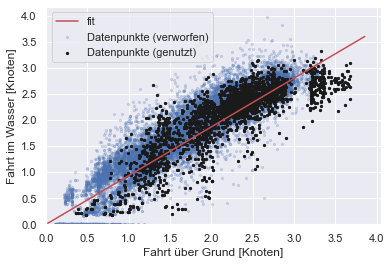

In [3]:
a, ind, ax = plot.fit_BSP(d06)
print(a)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.9612833010266805


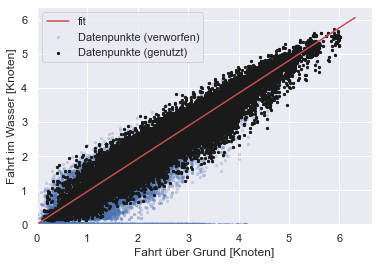

In [4]:
a, ind, ax = plot.fit_BSP(d08)
print(a)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.9979853329524235


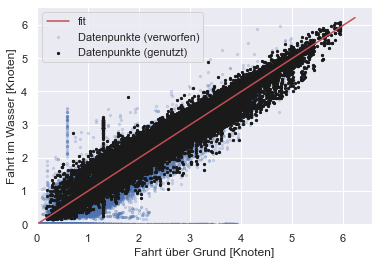

In [5]:
a, ind, ax = plot.fit_BSP(d11)
print(a)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.9934430384923875


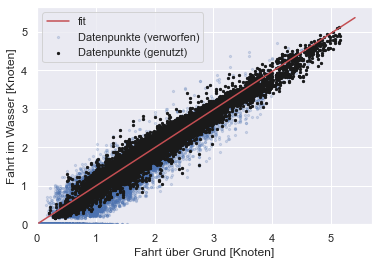

In [6]:
a, ind, ax = plot.fit_BSP(d12)
print(a)

Hier vergleichen wir die SOG mit der BSP.
In dieser Grafik sieht man alle Datenpunkte, die wir für je ein Jahr geladen haben (wir berücksichtigen hier nur die letzten beiden Tage der Messfahrten in 2006, weil wir nur an diesen beiden Tagen gesegelt sind). Die blaue Wolke zeigt alle Daten, die schwarzen Punkte nur die Daten, die zur Kalibration des Log geeignet sind. Dafür verlangen wir, dass

- die Richtung der Bewegnung über Grund (vom GPS) und die Richtung, in die der Bug zeigt, übereinstimmen, weil es in dieser Position die Drift keine Rolle spielt.
- die Geschwindigkeit > 0.4 kn ist, weil bei Geschwindigkeiten unter dieser Schwelle das Log noch nicht arbeitet.
- die Geschwindigkeit des Schiff sich in diesem Zeitraum nur wenig geändert hat (Aus technischen Gründen hinkt die SOG der BSP immer etwas hinterher. Messungen, die z.B. beim Aufstoppen aufgenommen wurden, sind daher fur die Logkalibration nicht geeignet).

Die rote Linie zeigt einen Fit durch die schwarzen Punkte.

Wenn man die Grafiken für die Daten aus jedem einzelnen Jahr anschaut, dann sieht man, dass die Korrekturfaktoren für die BSP ("boat speed" - Geschwindigkeit mit dem Log gemessen) offensichtlich gut gewählt sind und wir ab jetzt die BSP für alle Winkel verwenden konnen, um Polardiagramme zu erzeugen.

## Polardiagramme

### Filtern der Daten

Bevor wir die Daten zu Polardiagrammen zusammenstellen, müssen wir sie filtern, denn nicht jeder Datenpunkt kann dafür genutzt werden. In diesem Abschnitt untersuchen wir, welche Filter sinnvoll sind. Die verschiedenen Filter, die wir auf die Daten anwenden, sollen verschiedene Effekte berücksichtigen: Zuerst beschränken wir uns auf die Messpunkte, die beim Segeln ohne Hilfe der Ruderer aufgenommen wurden. Dann verlangen wir, dass die Geschwindikgeit sich nur langsam ändert, denn wenn z.B. der Bug in den Wind gedreht wird, dann hat das Schiff zunächst noch eine Geschwindigkeit, die aber schnell abnimmt. Das bedeutet nicht, das wir gegen den Wind segeln können, sondern nur dass die Daten, die direkt nach einer Richtungsänderung, direkt nach dem Hissen des Segels oder in einer Windböhe aufgenommen wurden, herausgefiltert werden müssen. Außerdem ändert sich der Wind sehr viel schneller, als das Schiff seine Geschwindigkeit anpassen kann. Deshalb glätten wir die Windgeschwindigkeit etwas, um diesen Effekt auszugleichen. Dafür wählen wir eine Funktion, die nur vorausgegangene, aber nicht zukünftige Messwerte verwendet; deshalb erscheinen die Maxima im geglätteten Wind immer etwas später. Die nächste Grafik zeigt ein Beispiel dafür.

Text(0, 0.5, 'Windgeschwindigkeit [Knoten]')

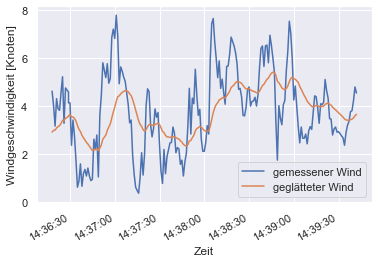

In [7]:
dplot = d11['2011-05-02 14:36:18':'2011-05-02 14:39:42']
ax = dplot.plot(y=['TWS', 'TWS_s'])
ax.legend(['gemessener Wind', 'gegl\u00e4tteter Wind'])
ax.set_xlabel('Zeit')
ax.set_ylabel('Windgeschwindigkeit [Knoten]')

In der nachsten Grafik schauen wir uns den Winkel zum Wind an. Dabei bedeutet $0^{\circ}$, das die Galeere "im Wind" steht (der Bug in den Wind zeigt), während $180^{\circ}$ meint, das der Wind von achtern kommt und die Galeere "vor dem Wind" segelt. Das Vorzeichen kann dabei positiv oder negativ sein, je nachdem ob der Wind von Steuerbord oder von Backbord kommt. 
Durch diese Skala kann es bei achterlichem Wind zu scheinbaren Spüngen kommen (z. B. um 14:36:45 in the Grafik), wenn der Wind von $+179^{\circ}$ zu $-179^{\circ}$ wechselt. Da wir in der folgenden Analyse nicht zwischen Backbord und Steuerbord unterscheiden, genügt es, den Betrag des Windwinkels zu betrachten und so das Problem zu vermeiden. Außerdem sieht man in der Grafik, dass die gemessene Windrichtung sehr schnell hin- und herspringt, weil der Windmesser im Wind flattert. Dies ist besonders bei schwachen Wind der Fall und bei Wind vom Bug, wenn das Segel den Windmesser abdeckt. Der Windmesser ist zwar mit einem "twin fin" System ausgestattet, dass ein Hin-und Herflattern vermeiden soll, aber die gemessene Windrichtung schwankt immer noch im Sekundenbereich. Wenn wir dies nicht berücksichtigen, dann werden bei der Konstruktion eines Polardiagrams viele Messwerte bei unpassenden Windwinkeln einsortiert. 
Deshalb glätten wir auch die Windrichtung.

Text(0, 0.5, 'Winkel zum Wind [Grad]')

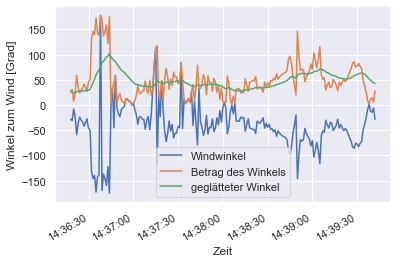

In [8]:
ax = dplot.plot(y=['TWA', 'absTWA', 'absTWA_s'])
ax.legend(['Windwinkel', 'Betrag des Winkels', 'gegl\u00e4tteter Winkel'])
ax.set_xlabel('Zeit')
ax.set_ylabel('Winkel zum Wind [Grad]')

Um sinnvolle Parameter zum Filtern zu finden und zu zeigen, wie sich die einzelnen Filter auswirken, verwende ich im Folgenden den Datensatz von 2011 als Beispiel.

In [9]:
sail = (d11['Segel_s'] > .7) & (d11['row_s'] < 0.01)

d11['BSP_diff_s'] = np.abs(d11['BSP'].diff().rolling(20, center=True, win_type='triang').mean())
con = d11['BSP_diff_s'] < 0.02
conTWA = np.abs(d11['absTWA_s'].diff()) < 1.0

Hier schauen wir mal, wie viele Punkte eigentlich noch übrig bleiben, wenn die oben definierten Filter angewendet werden.

In [10]:
print('Anzahl Datenpunkte mit Segel und ohne Ruder', sail.sum())
print('zusätzliche Bedingung: Fast konstante Geschwindigkeit', (sail & con).sum())
print('zusätzliche Bedingung: Fast konstanter Windwinkel', (sail & con & conTWA).sum())

Anzahl Datenpunkte mit Segel und ohne Ruder 23997
zusätzliche Bedingung: Fast konstante Geschwindigkeit 20901
zusätzliche Bedingung: Fast konstanter Windwinkel 17017


In [11]:
def make_polar(df, anglebins=np.arange(0, 181., 15.01),
               speedbins=np.arange(1., 16., 3.),
               anglecol='absTWA_drift_s', speedcol='TWS_s'):
    df['ang_bin'] = pd.cut(df[anglecol], anglebins)
    df['v_bin'] = pd.cut(df[speedcol], speedbins)
    df['BSP_diff_s'] = np.abs(df['BSP'].diff().rolling(20, center=True,
                                                       win_type='triang').mean())
    dp = df.loc[(df['Segel'] > 0.7) &
                (df['row_s'] < 0.01) &
                (np.abs(df['BSP_diff_s'].diff()) < 0.02) &
                (np.abs(df['absTWA_s'].diff()) < 1.)]
    polar = dp.groupby(['ang_bin', 'v_bin'])
    return polar, dp

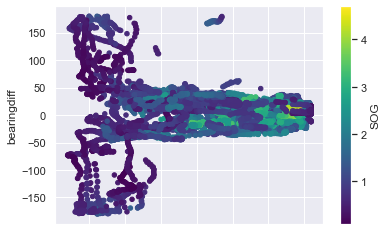

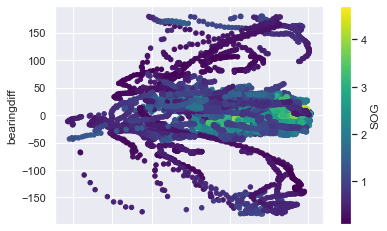

In [12]:
dp = d11[sail & con & conTWA]
dp.plot('absTWA_s', 'bearingdiff', c='SOG', kind='scatter',
        colorbar=True, colormap='viridis')
dp.plot('absTWA_drift_s', 'bearingdiff', c='SOG', kind='scatter',
        colorbar=True, colormap='viridis')

Alle Punkte mit Segel und ohne Rudern:

In [13]:
d11['ang_bin'] = pd.cut(d11['absTWA_s'], np.arange(0, 181., 30.0001))
d11['v_bin'] = pd.cut(d11['TWS_s'], np.arange(0., 16.1, 4.))

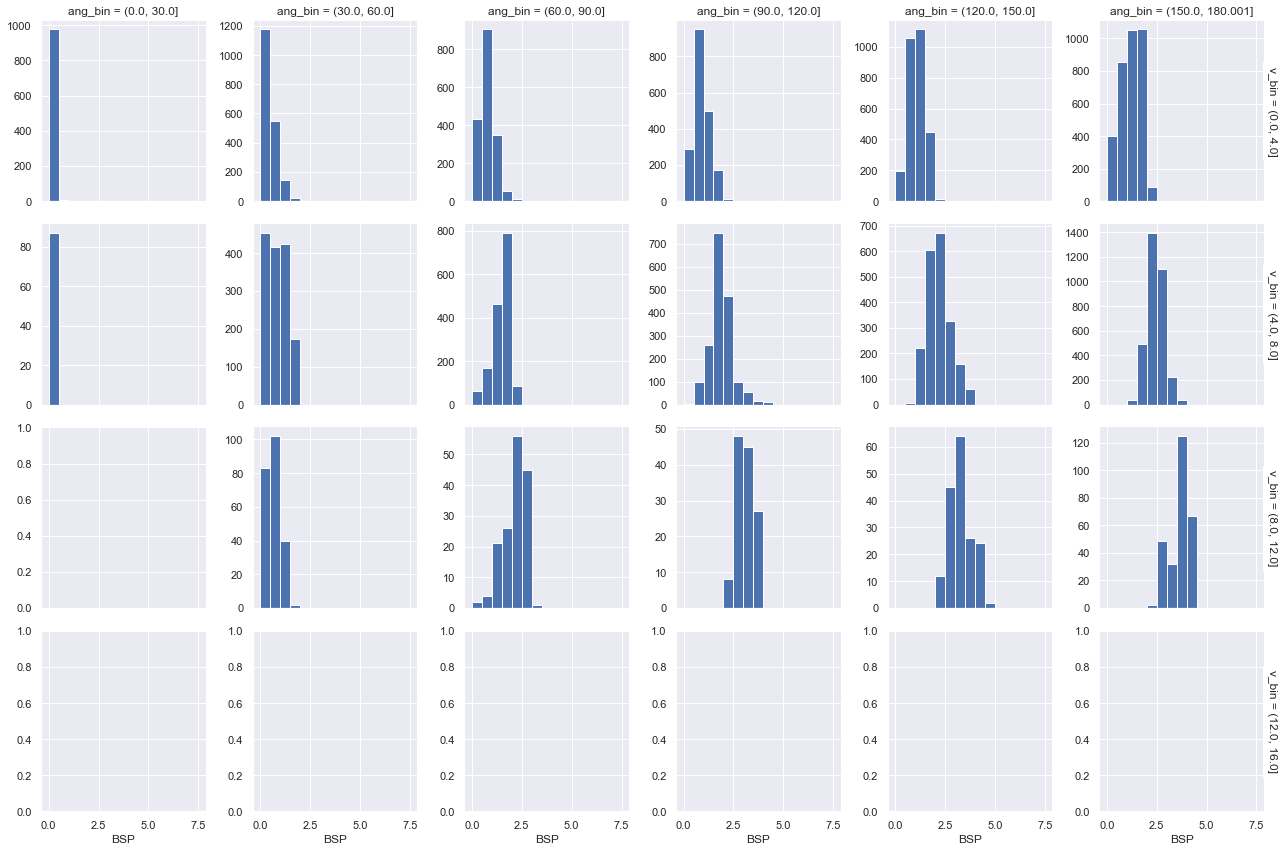

In [14]:
dp = d11.loc[sail]
g = sns.FacetGrid(dp, col='ang_bin', row='v_bin', margin_titles=True, sharey=False)
bins = np.arange(0, 8, .5)
g.map(plt.hist, 'BSP', bins=bins)

Man sieht schon, dass (außer in der letzten Zeile, wo wir einfach sehr wenige Daten haben) die meisten Verteilungen sehr gut um einen Mittelwert herum liegen. Allerdings sind manche Verteilungen noch so breit, dass man sieht, dass die Werte etwas gefilteret werden müssen. In der nächsten Grafik verweden wir nun die geglätteten Werte für Windgeschwindikeit und -winkel. Außerdem filtern wir die Zeiten heraus, bei denen sich die Bootsgeschwindigkeit oder der Windwinkel schnell ändern. Dabei ist es schwer, genau zu definieren, an welcher Stelle man hier abschneiden soll. Ich habe die Werte so gewählt, das nur die wirklich extremen Werte (wenn zum Beispiel eine enge Kurve gesegelt wird) herausgenommen werden. 

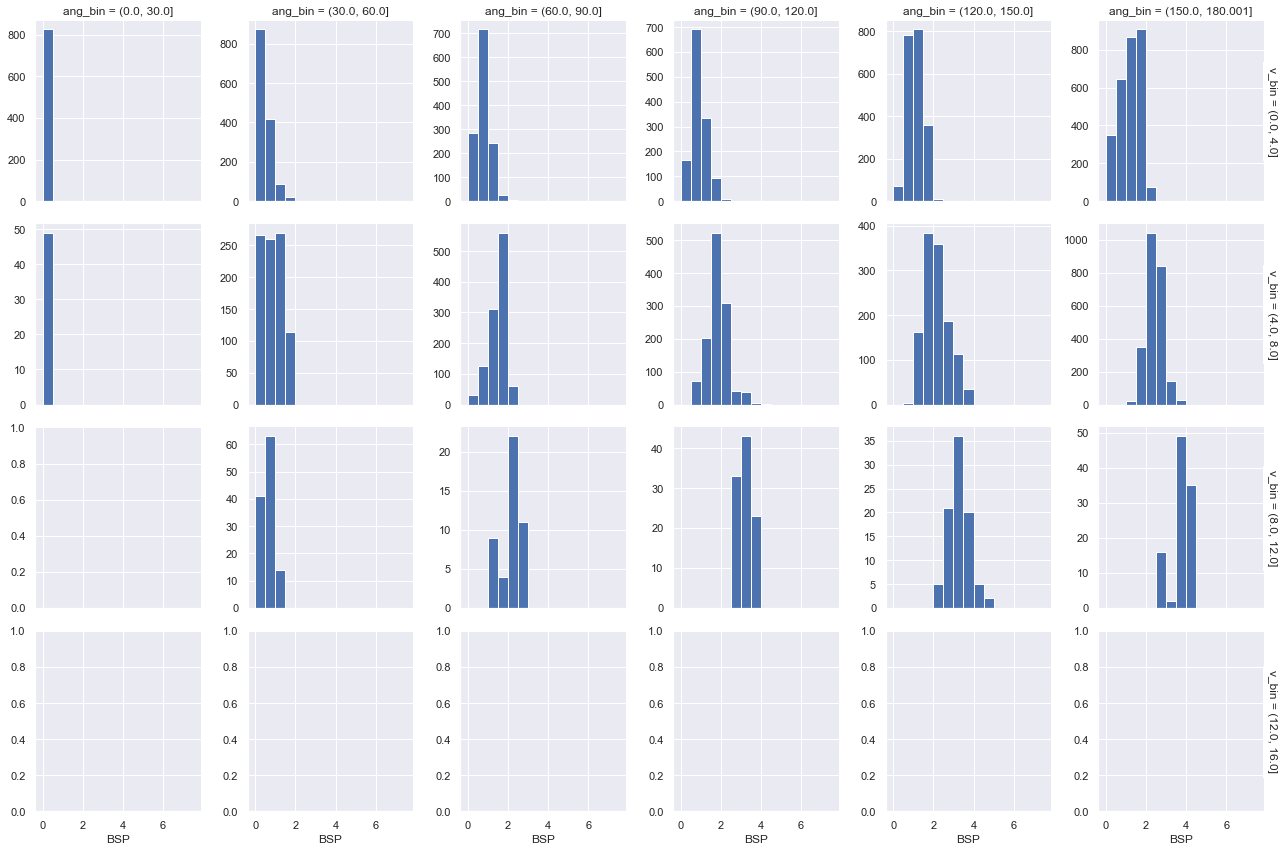

In [15]:
dp = d11.loc[sail & con & conTWA]
g = sns.FacetGrid(dp, col='ang_bin', row='v_bin', margin_titles=True, sharey=False)
bins = np.arange(0, 8, .5)
g.map(plt.hist, 'BSP', bins=bins)

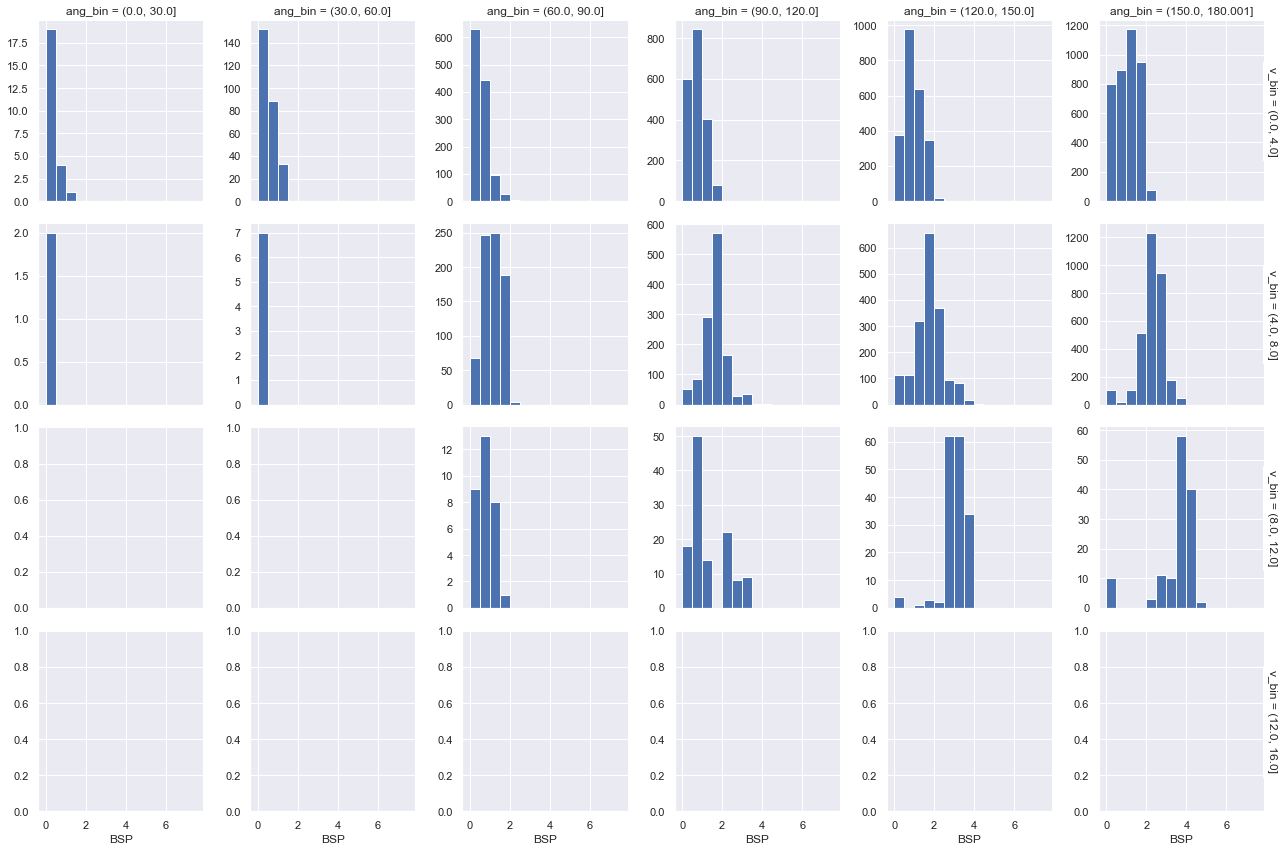

In [16]:
d11['ang_bin'] = pd.cut(d11['absTWA_drift_s'], np.arange(0, 181., 30.0001))
d11['v_bin'] = pd.cut(d11['TWS_s'], np.arange(0., 16.1, 4.))
dp = d11.loc[sail & con & conTWA]
g = sns.FacetGrid(dp, col='ang_bin', row='v_bin', margin_titles=True, sharey=False)
bins = np.arange(0, 8, .5)
g.map(plt.hist, 'BSP', bins=bins)

Die Grafik sieht im wesentlichen noch so ähnlich aus wie darüber. Einige der Verteilungen sind etwas schmaler geworden, aber laut dieser Grafik segeln wir immer noch manchmal gegen den Wind. Das haben wir so aber nie direkt beobachtet. Offensichtlich sind die Filter also noch nicht richtig eingestellt. Deshalb schauen wir jetzt mal ein paar der fraglichen Phasen an, um zu verstehen, was da passiert ist.

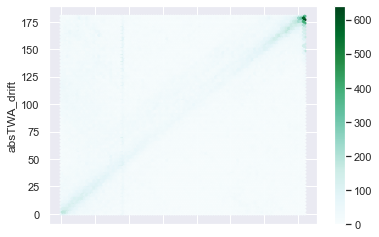

In [17]:
d11.plot('absTWA', 'absTWA_drift', kind='hexbin')

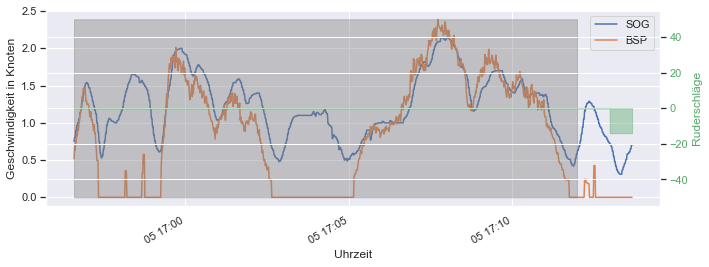

In [18]:
df = d11['2011-05-05 16:56:36+0200': '2011-05-05 17:13:40+0200']
ax = plot.speeds(df, figsize=(11, 4))

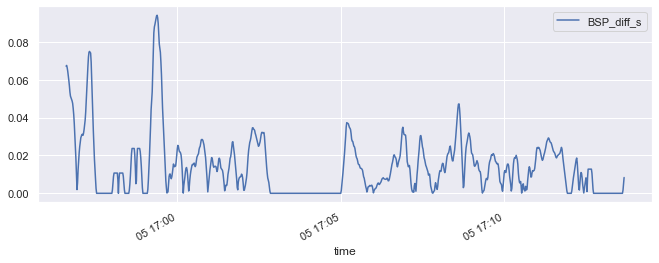

In [19]:
ax = df.plot(y=['BSP_diff_s'], figsize=(11, 4))

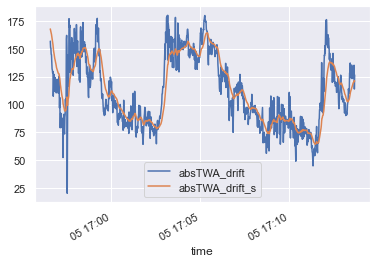

In [20]:
df.plot(y=['absTWA_drift', 'absTWA_drift_s'])

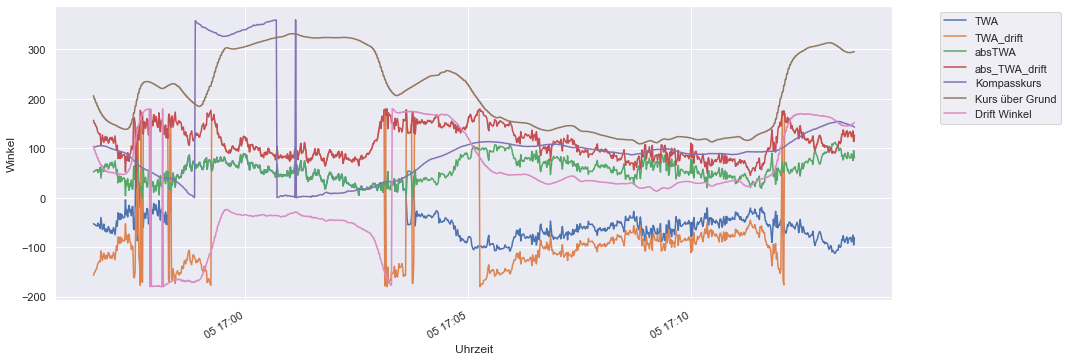

In [21]:
ax = df.plot(y=['TWA', 'TWA_drift', 'absTWA', 'absTWA_drift', 
                'HDC', 'COG', 'bearingdiff'], figsize=(15, 6))
ax.legend(['TWA', 'TWA_drift', 'absTWA', 'abs_TWA_drift',
           'Kompasskurs', 'Kurs über Grund', 'Drift Winkel'],
         bbox_to_anchor=(1.05, 1.))
ax.set_xlabel("Uhrzeit")
#ax.set_ylim(-20, +120)
out = ax.set_ylabel("Winkel")

In diesem Beispiel sind die fraglichen Werte im ersten Drittel und im zweiten Drittel der Grafik zu finden, ca 17:00-17:03 und 17:06-17:10. Auf dem obersten Plot sieht man da nichts Ungewöhnliches, wenn man sich die mit dem Log und die mit dem GPS gemessene Geschwindigkeit anschaut. Auf der nächsten Grafik (direkt über diesem Text) zeigen wir den Kurs über Grund (vom GPS) und den Kompasskurs, sowie die Drift (die Differenz dieser beiden Werte). Zur fraglichen Zeit ist das Schiff deutlich abgedriftet mit einem Driftwinkel um $30^{\circ}$. Zur Kontrolle sind auf der nachsten Grafik die Kurse zum fraglichen Zeitpunkt dargestellt. Dort sieht man deutlich, dass die nominelle Fahrt im Wasser (die Richtung, in die der Bug des Schiffes zeigt - schwarze Pfeile) und die wahre Bewegungsrichtung des Schiffs, die das GPS aufzeichnet (blaue Pfeile) sich unterscheiden. Der nominelle Kurs ist am Wind, aber unter Berücksichtigung der Drift erreichen wir in Wirklichkeit nur "halben Wind" (rechter Winkel zwischen grünen und blauen Pfeilen). 

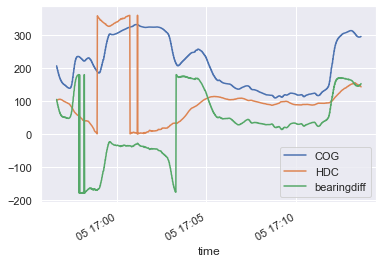

In [22]:
df.plot(y=['COG', 'HDC', 'bearingdiff'])

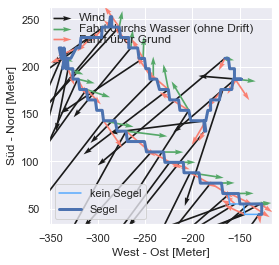

In [23]:
ax = plot.course(df, scale=4, n=30)

Möglicherweise hat der Steuermann hier den Kurs nicht optimal eingestellt und ein Teil der Drift könnte verhindert werden, wenn der Bug des Schiffs nicht in den Wind gestellt wird. Wenn der Bug in den Wind zeigt, dann wird die Drift größer (siehe nächste Grafik, mehr Details unten im Kapitel Drift) ohne dass das Schiff tatsächlich in den Wind navigieren könnte.  Im Folgenden werden wir die wahre Bewegungsrichtung im Wasser betrachten, nicht die Richtung, in die der Bug zeigt. Moderne Schiffe haben normalerweise einen Kiel und die Abdrift ist klein. Auch werden sie bei solchen Tests in der Regel "ideal" gesegelt, also so, dass die größtmögliche Geschwindigkeit erreicht wird. In den Versuchen zu römischen Kriegsschiffen ist das nicht gegeben, weil wir vom ersten Fahrtag an Messwerte aufgezeichnet haben und die verschiedenen Schiffsführer zunächst nicht mit den Besonderheiten dieser Schiffe vertraut waren (da fast 2000 Jahre vergangen sind, seit die Römer diese Schiffe gesegelt haben).

**OK, es sind immer noch einige Punkte übrig, die bei kleinen Winkeln und positiven Geschwindigkeiten liegen, aber nicht mehr viele.** Das mache ich iterativ so lange, bis alles, das ich nicht glaube, weggefiltert ist. Dabei habe ich folgende Punkte erkannt und gelöst:

  - Am Anfang habe ich nur für das Segeln die ersten und letzten ca. 1.5 min ignoriert, weil in dieser Zeit ja das Segel erst mal gesetzt und ausgerichtet werden muss (bzw. quer gestellt und eingeholt). Ich habe ausserdem festgestellt, dass viele der fraglischen Bereiche direkt vor oder hinter einem Ruderabschnitt liegen. Hier können wir nicht auschließen, das da vielleicht schon ein "Halt Wasser" gegeben wurde oder die Ruderer ihrer Rimen ins Wasser getaucht haben, um sie besser in die Dollen einhängen zu können. Dashalb filtern wir nun auch Bereiche kurz vor oder nach dem Rudern (ca 1.5 min) heraus.
  - Ich haben den Filter, der prüft, ob die Schifftgeschwindigkeit sich nicht schnell ändert verschärft. Ein guter Wert, um wirklich alle fraglichen Bereuche herauszufiltern, ist eine maximale Änderung von 0.005 pro Sekunde, aber bei einer solchen Bedingung werden auch viele brauchbare Werte verworfen. Als Kompromiss schlage ich jetzt 0.007 als Grenzwert vor.

Wie man oben sieht, bleiben aber selbst im Bereich 30-60 Grad noch einige Punkte übrig. Ich gebe zu bedenken, dass diese alle zu sehr niedrigen BSP gehören, also verträglich mit der Beobachtung "kein Vortrieb" sind. Unten suche ich noch mal die fraglichen Bereiche heraus.

Nun können wir iterativ uns anschauen, welche Datenpunkte nicht herausgefiltert sind, die eine signifikante Geschwindigkeit nach vorn zeigen.

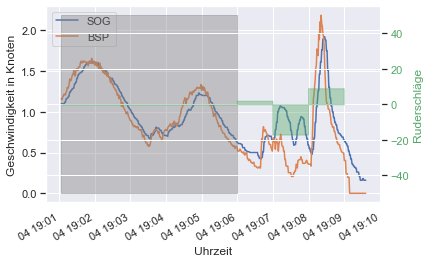

In [24]:
df = d11['2011-05-04 19:01:04+0200': '2011-05-04 19:09:36+0200']
ax = plot.speeds(df)

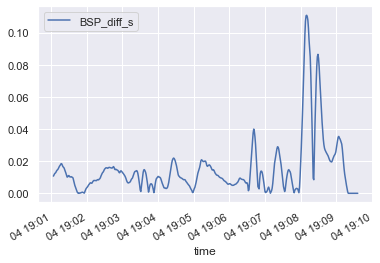

In [25]:
ax = df.plot(y=['BSP_diff_s'])

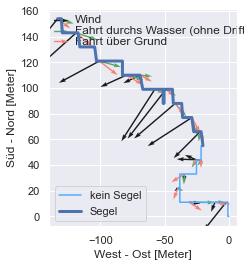

In [26]:
ax = plot.course(df, n=30, scale=5)

Text(0, 0.5, 'Winkel')

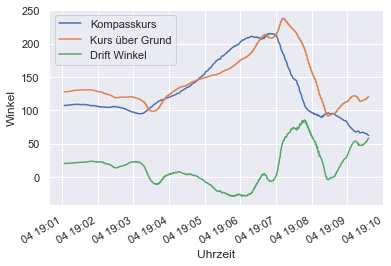

In [27]:
ax = df.plot(y=['HDC', 'COG', 'bearingdiff'])
ax.legend(['Kompasskurs', 'Kurs über Grund', 'Drift Winkel'])
ax.set_xlabel("Uhrzeit")
ax.set_ylabel("Winkel")

Wenn ich mir das anschaue (der fragliche Punkt ist um 19:03:24 Uhr), dann ändert sich die Geschwindigkeit hier schnell, aber gerade zwischen 19:03 und 19:04 gibt es noch mal ein lokales Maximum, wo dann die lokare Änderung null ist. Meiner Meinung nach ist das ein pathologischer Fall und ich habe keine gute Idee, wie man solche Punkte auch noch erwischt, ohne zu viele brauchbare Punkte mit zu verwerfen.

### Vergleich der Jahre 2006, 2008, 2011 und 2012

Hier zeige ich einen Überblick von Polardiagrammen. Fur jeden Datensatz erzeuge ich die gleichen Diagramme. Die Daten, die in diese Polardiagramme hineingehen, sind wie oben beschrieben gefiltert.

1. Das linke Diagram benutzt in jedem Bin den Median, da der von den nicht gefilterten Ausreissern nicht so stark beeinflusst wird.
2. Das mittelere Diagram bildet den Mittelwert.
3. Das rechte Diagram zeigt den Logarithmus zur Basis 10 der Anzahl der Werte in jedem Bin.

In [28]:
speedbins=np.arange(1.5,16,3.)

mk_polar = make_polar
# mk_polar = plots.make_polar

kwdrift = {'speedbins': speedbins, 'anglecol': 'absTWA_s'}
p06, dp06 = mk_polar(d06, **kwdrift)
p08, dp08 = mk_polar(d08, **kwdrift)
p11, dp11 = mk_polar(d11, **kwdrift)
p12, dp12 = mk_polar(d12, **kwdrift)

p06corr, dp06 = mk_polar(d06, speedbins=speedbins)
p08corr, dp08 = mk_polar(d08, speedbins=speedbins)
p11corr, dp11 = mk_polar(d11, speedbins=speedbins)
p12corr, dp12 = mk_polar(d12, speedbins=speedbins)

In [29]:
def polar3(df, dfcorr=None, col='BSP'):
    fig, axes = plt.subplots(ncols=3, subplot_kw={'polar': True}, figsize = (13,7))
    ax1 = plot.polar(df.median()[col].unstack(), ax=axes[0],
                     labeltext='{:4.1f}-{:4.1f} kn')
    ax2 = plot.polar(df.mean()[col].unstack(), ax=axes[1],
                     labeltext='{:4.1f}-{:4.1f} kn')
    ax3 = plot.polar(np.log10(df.count()['BSP'].unstack()),
                     ax=axes[2], labeltext='{:4.1f}-{:4.1f} kn')
    if not dfcorr is None:
        ax1.set_prop_cycle(None)
        ax1 = plot.polar(dfcorr.median()[col].unstack(), ax=axes[0],
                         labeltext='__no_legend__', lw=3)
        ax2.set_prop_cycle(None)
        ax2 = plot.polar(dfcorr.mean()[col].unstack(), ax=axes[1],
                         labeltext='__no_legend__', lw=3)
        
    ax1.set_title('Polardiagram - Median')
    ax2.set_title('Polardiagram - Mean')
    ax3.set_title ('Log10(Anzahl Datenpunkte per bin)')
    ax1.legend(loc='upper left')

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


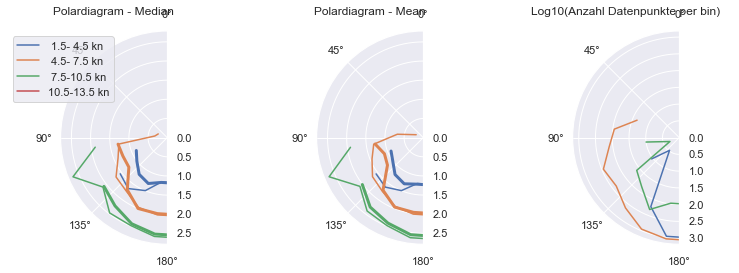

In [30]:
polar3(p06, p06corr)

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


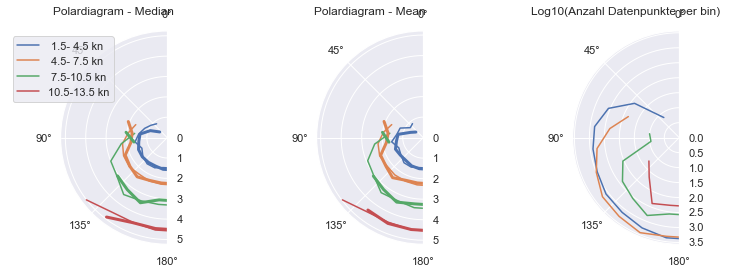

In [31]:
polar3(p08, p08corr)

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


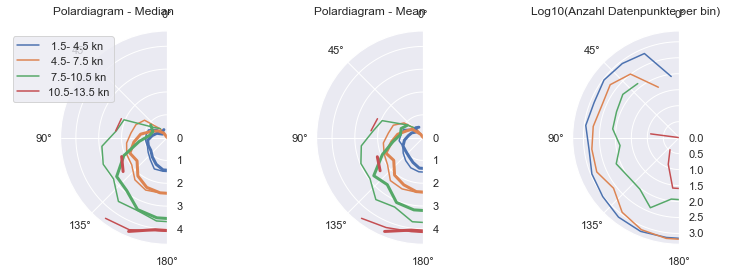

In [32]:
polar3(p11, p11corr)

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


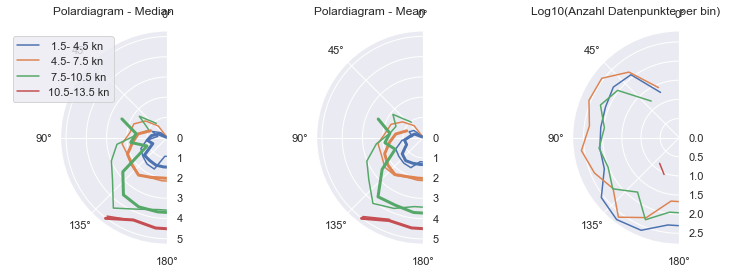

In [33]:
polar3(p12, p12corr)

**Drift correction seems to work for 08 and 11, but not for 06 and 12. Why?**
Same strange stuff around 90 deg happened before, but I did not notice, because I did not compare the two as closely. Yeah for better plotting?

Fur die Geschwindigkeiten unter 6 kn sehen die Grafiken allesamt relativ gut aus. Bei stärkerem Wind haben wir einfach zu wenig Datenpunkte, um wirklich viel aussagen zu konnen. Bei schwachem Wind konnte man die Unterteilung vermutlich sogar noch etwas feiner machen, allerdings kann man das dann nicht mehr gut mit 2006 vergleichen, wo wir in der Tat nur eine sehr kurze Messzeit hatten.

Zu besseren Vergleichbarkeit werden nun die Polardigramme aller Messjahre für jeweils eine bestimmte Geschwindigkeit übereinander dargestellt.

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


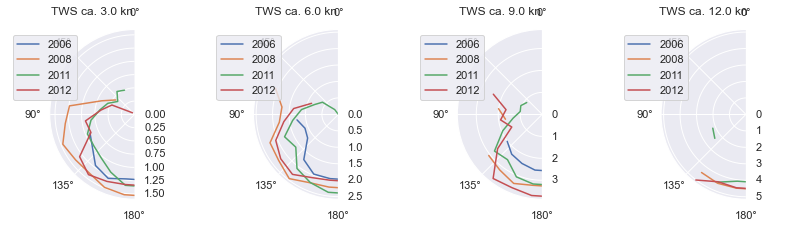

In [34]:
pol06 = p06corr.mean()['BSP'].unstack()
pol08 = p08corr.mean()['BSP'].unstack()
pol11 = p11corr.mean()['BSP'].unstack()
pol12 = p12corr.mean()['BSP'].unstack()

fig, axes = plt.subplots(ncols=4, subplot_kw={'polar': True}, figsize = (14, 5))

for i, col in enumerate(pol06.columns):
    for df in [pol06, pol08, pol11, pol12]:
        plot.polar(df.iloc[:, i].to_frame(), ax=axes[i])
    axes[i].legend(['2006', '2008','2011','2012'], loc='upper left')
    axes[i].set_title('TWS ca. '+ str(col.mid) + ' kn')

Ich lese hier ab, dass die Lusoria Regina am langsamsten ist. Das kann natürlich verschiedene Gründe haben, einer davon ist, dass wir 2006 noch nicht so gut Segeln konnten und nicht das beste aus dem Schiff herausgeholt haben...
Es scheint auch so zu sein, dass wir 2012 tendenziell etwas schneller waren als 2011. Vielleicht hat sich das das größere Segel ausgewirkt. Andererseits ist der Unterschied nicht besonders gross und ich bin wir nicht sicher, das sich die beiden Verteilungen statistisch signifikant unterscheiden (Das könnte man natürlich mit einem KS-Test prüfen, wenn wir das wollen). Für das Buch würde ich die Plots vielleicht auch doch wieder mit breiteren bins machen.

Was liest du hier noch ab?

Ich habe auch mal die Bücher aufgeschlagen und versucht diese neuen Kurven mit dem zu vergleichen, was schon gedruckt ist. Da scheint es mir (auch wenn wir in IDL etwas andere bins verwendet haben), dass die neue Auswertung immer etwas schneller ist. Woran mag das liegen? Haben wir damals die BSP Kalibration nicht so gut im Griff gehabt? Ich dachte immer, das ware einer der schwachsten Punkte in der Analyse, wahrend hier der Vergleich (s. oben) ja zeigt, das wir dieses Problem nun gelöst haben. Wir finde ich das am besten heraus, wo der Unterschied herkommt?

## Drift

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


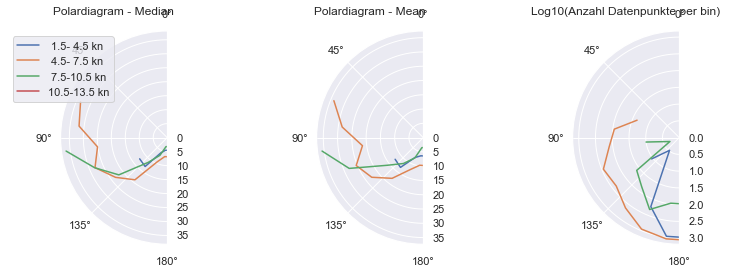

In [35]:
polar3(p06, col='absbearingdiff')

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


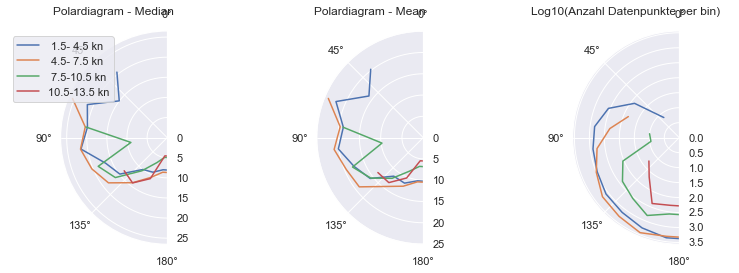

In [36]:
polar3(p08, col='absbearingdiff')

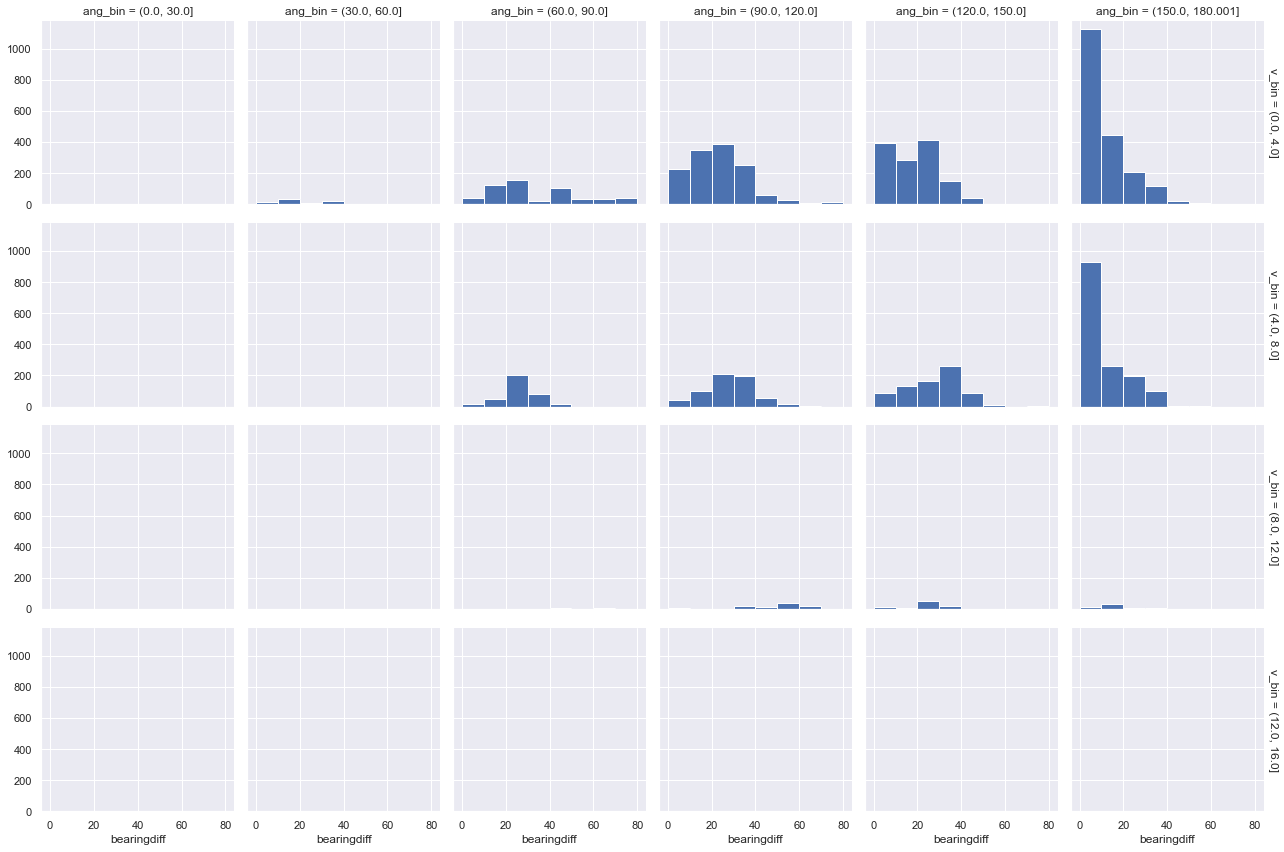

In [37]:
g = sns.FacetGrid(dp, col='ang_bin', row='v_bin', margin_titles=True)
bins = np.arange(0, 90, 10)
g.map(plt.hist, 'bearingdiff', bins=bins)

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


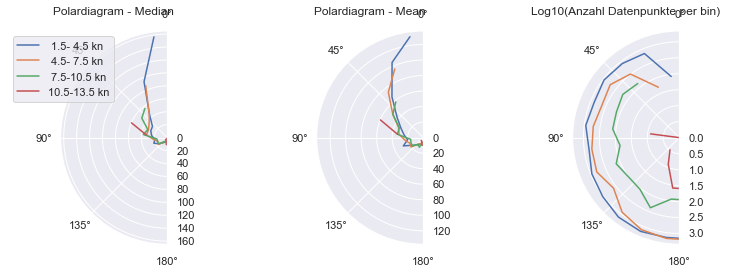

In [38]:
polar3(p11, col='absbearingdiff')

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


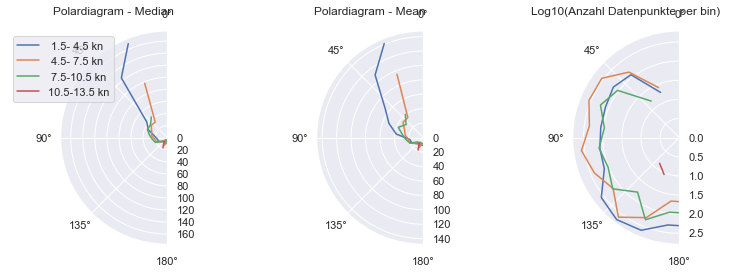

In [39]:
polar3(p12, col='absbearingdiff')

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


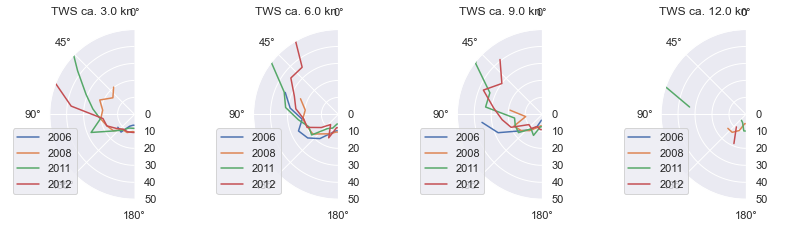

In [40]:
pol06bear = p06.mean()['absbearingdiff'].unstack()
pol08bear = p08.mean()['absbearingdiff'].unstack()
pol11bear = p11.mean()['absbearingdiff'].unstack()
pol12bear = p12.mean()['absbearingdiff'].unstack()

fig, axes = plt.subplots(ncols=4, subplot_kw={'polar': True}, figsize = (14, 5))

for i, col in enumerate(pol06.columns):
    for df in [pol06bear, pol08bear, pol11bear, pol12bear]:
        plot.polar(df.iloc[:, i].to_frame(), ax=axes[i])
    axes[i].legend(['2006', '2008','2011','2012'], loc='lower left')
    axes[i].set_title('TWS ca. '+ str(col.mid) + ' kn')
    axes[i].set_ylim(0, 50.)

## Vergleich mit Widerstandsmessungen im Tank

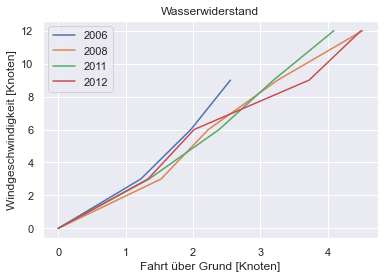

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)

for df in [pol06, pol08, pol11, pol12]:
    ax.plot(np.hstack(([0], df.to_numpy()[-1, :])),
            [0] + [k.mid for k in df.keys()])

ax.legend(['2006', '2008','2011','2012'], loc='upper left')
ax.set_xlabel(u'Fahrt über Grund [Knoten]')
ax.set_ylabel('Windgeschwindigkeit [Knoten]')
out = ax.set_title('Wasserwiderstand')
out = ax

In [42]:
# Somehow te fact that pandas functions are called in the cell above means that 
# that the figure is not displayed automatically. So we do it in another cell.
out = ax

Nun vergleichen wir die am Nachbau gemessenen Geschwindigkeiten mit den Widerstandsmessungen am Model im Tank zu vergleichen (siehe Kapitel von XXX in diesem Band). Im Tank werden die Modelle bei definierter Geschwindigkeit bewegt und die dazu notwendige Kraft gemessen. Am Nachbau kennen wir die Kraft, die auf das Schiff wirkt, nicht genau, aber die Kraft, die das Schiff beim Segeln antreibt, ist in etwa proportional zur Windgeschwindigkeit. Die dargestellten Werte sind alle bei Wind von achtern gemessen. In dieser Position ist es leicht, das Segel optimal einzustellen. 
Für alle von Wasser umströmten Objekte gilt, dass die benötigte Kraft exponentiell mit der Geschwindigkeit steigt und in den Messungen der Schiffbauversuchsanstalt in Potsdam wurde dies auch für alle getesteten Modelle römischer Kriegsschiffe bestätigt. In der Grafik ist dieser Zusammenhang nicht gut zu erkennen, weil die gemessenen Geschwindigkeiten relativ klein sind und von den bereits diskutierten Messungenauigkeiten beeinflusst werden. Die Daten der Schiffsbauversuchsanstalt zeigen zun Beispiel, dass für das Schiff vom Typ Oberstimm (2008) nur eine Kraft von 0,22 kN benötigt wird, um 4 kn zu erreichen, während 1 kN für 8,0 kn erforderlich ist. So schnell sind wir aber im Experiment nie gesegelt (der Mast brach, bevor diese Geschwindigkeit erreicht werden konnte). Andererseits stimmen die am Nachbau gemessenen Werte qualitativ gut mit den Widerstandsmessungen am verkleinerten Modell im Tank überein. Bei einer Geschwindigkeit von 3 kn ergibt der Versuch im Wassertank, dass die Lusoria Regina (2006) ca 80% mehr Antriebskraft erfordert als die Victoria (2008). Auch am Nachbau erfordert die Regina durchgängig einen stärkeren Wind als die Victoria, um eine bestimmte Geschwindigkeit über Grund zu erreichen. 

Im Vergleich der Victoria und der Lusoria Rhenana (2011 und 2012) ergeben die Tests im Tank, dass die Victoria eine geringere Kraft erfordert. Am Nachbau hingegen unterscheiden sich diese beiden Schiffe kaum.

## Abspeichern der Ergebnisse
Jetzt speichern wir die Polardiagramme jeweils als Datei ab.

In [43]:
if not os.path.exists('../polar_diagrams'):
    os.makedirs('../polar_diagrams')

for p, year in zip([p06, p08, p11, p12], ['2006', '2008', '2011', '2012']):
    p.mean().to_csv(f'../polar_diagrams/TWA_{year}.dat', float_format='%4.2f')

for p, year in zip([p06corr, p08corr, p11corr, p12corr], ['2006', '2008', '2011', '2012']):
    p.mean().to_csv(f'../polar_diagrams/TWAcorr_{year}.dat', float_format='%4.2f')